# 1. Import Dependencies

In [2]:
import cv2
import os
import numpy as np
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
import matplotlib.pyplot as plt
from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold, cross_val_score
import pickle
%matplotlib inline

# 2. Coding the Template

In [3]:
class Face:

    def __init__(self,):
       
        self.directory = ""
        self.target_size = (160,160)
        self.detector = MTCNN()
        self.embedder = FaceNet()
    
    def get_embedding(self, face_img):
        """Uses Keras's FaceNet to extract embeddings from input image

        Args:
            face_img (numpy array): 

        Returns:
            numpy array: (1,512) vector of facial embeddings 
        """
        face_img = face_img.astype('float32') 
        face_img = np.expand_dims(face_img, axis=0) 
        X = self.embedder.embeddings(face_img)
        return X[0] 
    
    def extract_face(self, filename):
        """
        Reads the input image and extracts faces using MTCNN,

        Args:
            filename (str): path to file 

        Returns:
            face_arr(numpy array): embeddings returned by self.get_embedding()
            (x,y,w,h): bouding box
            img(numpy array):  
        """
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']    # MTCNN is able to detect multiple faces in a image
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv2.resize(face, self.target_size)
        face_arr = self.get_embedding(face_arr)
        return face_arr ,(x,y,w,h), img
    

    def load_faces(self, dir):
        """loads images from each subfolder in classes directory


        Returns:
            embeddings for each image
        """
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face,_,_ = self.extract_face(path)
                FACES.append(single_face)
                
            except Exception as e:
#                 print(e)
                pass
        return FACES

    def load_classes(self, directory):
        """
        Args:
            directory (str): path to the folder containing classes

        Returns:
            (nparray of embeddings,corresponding label)
            
        """
        X_features=[]
        y_lables=[]
        self.directory=directory
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            X_features.extend(FACES)
            y_lables.extend(labels)       
        
        return np.asarray(X_features), np.asarray(y_lables)
    
               
    def predict(self, filename, model):
        """predict for a single image

        Args:
            filename (str): path to image
            model (_type_): pretraied model
        """
        fontScale = 1
        color = (171,32,253)
        thickness = 2
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        face,coord,img = self.extract_face(filename)
        face = face.reshape(1,-1)
        x,y,w,h = coord
        org = (x,y)
        pred = model.predict(face)
    
        pred = 'tired' if pred[0] == 1 else 'not_tired'   
        img = cv2.putText(img, f'{pred}', org, font, 
                   fontScale, color, thickness)
        plt.imshow(cv2.rectangle(img, (x, y), (x+w, y+h), (171,32,253), 2))


# 3. Extract features

In [4]:
train_directory = 'dataset/images/train/'

In [24]:
obj = Face()

In [ ]:
X_train,y_train = obj.load_classes(train_directory)

In [ ]:
test_directory='dataset/images/val/'

In [ ]:
X_test,y_test = obj.load_classes(test_directory)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

In [ ]:
np.savez_compressed('dataset.npz', X_train, y_train, X_test, y_test)

# 4. Load the dataset

In [5]:
data = np.load('dataset.npz')

In [6]:
X_train, y_train, X_test, y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [7]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(266, 512) (266,)
(51, 512) (51,)


- Change categorical variables

In [8]:
le = LabelEncoder()

In [9]:
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

# 5. Train the model

In [10]:
model = SVC(kernel='rbf', probability=True,gamma='scale',random_state=0)

In [11]:
model.fit(X_train,y_train)

SVC(probability=True, random_state=0)

In [14]:
y_pred = model.predict(X_test)

In [15]:
report = classification_report(y_test,y_pred)

In [16]:
print(report)

              precision    recall  f1-score   support

           0       0.91      0.88      0.90        34
           1       0.78      0.82      0.80        17

    accuracy                           0.86        51
   macro avg       0.84      0.85      0.85        51
weighted avg       0.87      0.86      0.86        51



In [17]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=0)

In [18]:
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [19]:
print(np.mean(scores))

0.8304558404558405


In [20]:
file = 'models/model.sav'
# pickle.dump(model, open(file,'wb'))

## Predicting for a single image

In [21]:
model = pickle.load(open(file,'rb'))

In [22]:
filename = ['dataset/test/tired/modi_tired.jpg','dataset/test/not/mamata_not.jpg']

1/1 [==============================] - 2s 2s/step


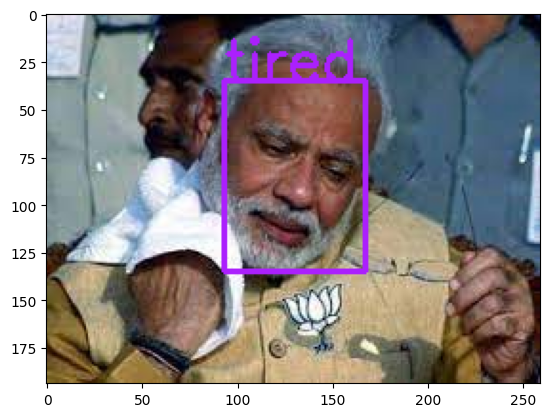

In [25]:
obj.predict(filename[0],model)

1/1 [==============================] - 0s 66ms/step


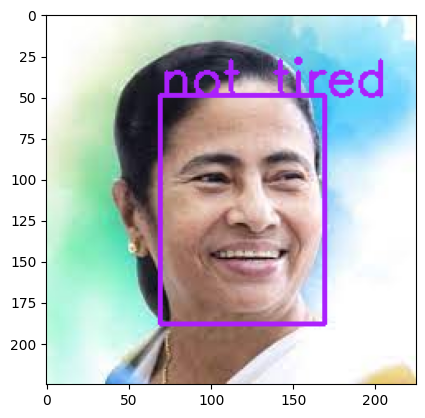

In [26]:
obj.predict(filename[1],model)